In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from common import *
from evaluation.metrics import *

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, GRU, Bidirectional, RepeatVector, TimeDistributed, Dropout, BatchNormalization

tf.keras.utils.set_random_seed(RANDOM_STATE)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-14 19:20:33.777606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 19:20:33.786306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 19:20:33.786626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Load dataset

In [3]:
data              = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Preprocessing

In [64]:
%%time

MARKER      = -9999
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 144
SHUFFLE     = False
TEST_SIZE   = 0.2

# 1. Generate time
data_with_time = generate_full_timestamp(data)

# 2. Imputing
#     data_imp = data_with_time.fillna(method='bfill')
data_imp = impute_data(data_with_time)

# 3. Feature engineering
data_fe = preprocess(data_imp)

# 4. Smoothing
data_smooth = smooth(data_fe)

# 5. Feature selection (select features)
cols = select_features(data_smooth)

# 6. Split dataset
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(data_smooth, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)

# 7. Mark anomaly
train_y_mark = copy(train_y)
#     for i in range(len(train_y)):
#         train_y_mark[i] = marking_data(train_y_mark[i], MARKER)

val_y_mark = copy(val_y)
#     for i in range(len(val_y)):
#         val_y_mark[i] = marking_data(val_y_mark[i], MARKER)

# 8. Feature selection (apply)
train_x = [d[cols] for d in train_x]
train_y = [d[cols] for d in train_y]
val_x   = [d[cols] for d in val_x]
val_y   = [d[cols] for d in val_y]
test_x  = [d[cols] for d in test_x]
train_y_mark = [d[cols] for d in train_y_mark]
val_y_mark   = [d[cols] for d in val_y_mark]

print("Final data")
print("- Train data(X, y)     :", np.shape(train_x), np.shape(train_y))
print("- Validation data(X, y):", np.shape(val_x),   np.shape(val_y))
print("- Test data(X)         :", np.shape(test_x))

- Data name: Imputing
  - Number of data: 3823222
  - Number of nan rows: 0
- Data name: Smoothing
  - Number of data: 3823222
  - Number of nan rows: 0


100%|██████████| 134/134 [00:14<00:00,  9.54it/s]


Data Split
- Train data(X, y)     : (20337, 288, 46) (20337, 288, 46)
- Validation data(X, y): (5216, 288, 46) (5216, 288, 46)
- Test data(X)         : (134, 288, 46)
Final data
- Train data(X, y)     : (20337, 288, 19) (20337, 288, 19)
- Validation data(X, y): (5216, 288, 19) (5216, 288, 19)
- Test data(X)         : (134, 288, 19)
CPU times: user 1min 16s, sys: 3.45 s, total: 1min 19s
Wall time: 1min 12s


In [65]:
BATCH_SIZE = 256

train_ds = generate_dataset(train_x, train_y_mark, batch_size=BATCH_SIZE)
val_ds   = generate_dataset(val_x, val_y_mark, batch_size=BATCH_SIZE)
test_ds  = generate_dataset(test_x, batch_size=1)

# 3. Modeling

In [73]:
from tensorflow.keras.layers import LSTMCell, RNN

class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn  = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(num_features)
    def warmup(self, inputs):
        X, *state = self.lstm_rnn(inputs)
        prediction = self.dense(X)
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)
        for n in range(1, self.out_steps):
            X = prediction
            X, state = self.lstm_cell(X, states=state, training=training)
            prediction = self.dense(X)
            predictions.append(prediction)
            
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions
    

model = FeedBack(256, *train_x[0].shape)
optimizer = tf.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [69]:
# from tensorflow.keras.metrics import RootMeanSquaredError

# model = Sequential([
#     Input(shape=(train_x[0].shape[0],train_x[0].shape[1])),
#     Bidirectional(GRU(units=256)),
#     RepeatVector(train_y[0].shape[0]),
#     Bidirectional(GRU(units=256, return_sequences=True)),
#     TimeDistributed(Dense(units=train_x[0].shape[-1]))
# ])
# model.compile(optimizer='adam', loss=CondLoss('mse', MARKER), metrics=[RootMeanSquaredError(), 'mae'])
# # model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
# model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirecti  (None, 512)              425472    
 onal)                                                           
                                                                 
 repeat_vector_10 (RepeatVec  (None, 288, 512)         0         
 tor)                                                            
                                                                 
 bidirectional_21 (Bidirecti  (None, 288, 512)         1182720   
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 288, 19)          9747      
 stributed)                                                      
                                                                 
Total params: 1,617,939
Trainable params: 1,617,939
N

# 4. Training

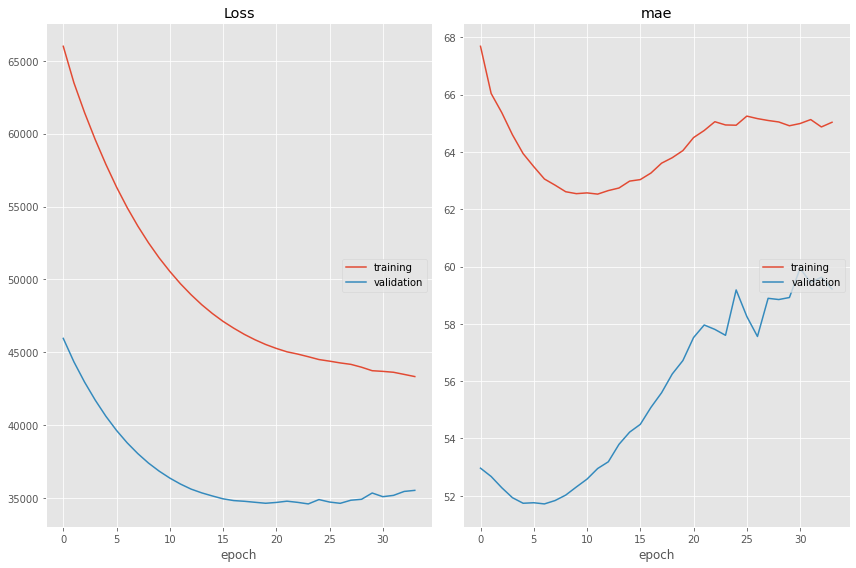

Loss
	training         	 (min: 43343.719, max: 65990.828, cur: 43343.719)
	validation       	 (min: 34611.355, max: 45962.090, cur: 35540.617)
mae
	training         	 (min:   62.529, max:   67.690, cur:   65.037)
	validation       	 (min:   51.714, max:   59.935, cur:   59.218)
80/80 [==============================] - 23s 288ms/step - loss: 43343.7188 - mae: 65.0370 - val_loss: 35540.6172 - val_mae: 59.2178 - lr: 6.5610e-04


In [74]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

model.fit(train_ds, validation_data=val_ds, epochs=1000,
          callbacks=[
              PlotLossesKeras(),
              EarlyStopping(patience=10, restore_best_weights=True),
              ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
          ]);

# 5. Check results

## 1) Training set

1/1 [==============================] - 5s 5s/step


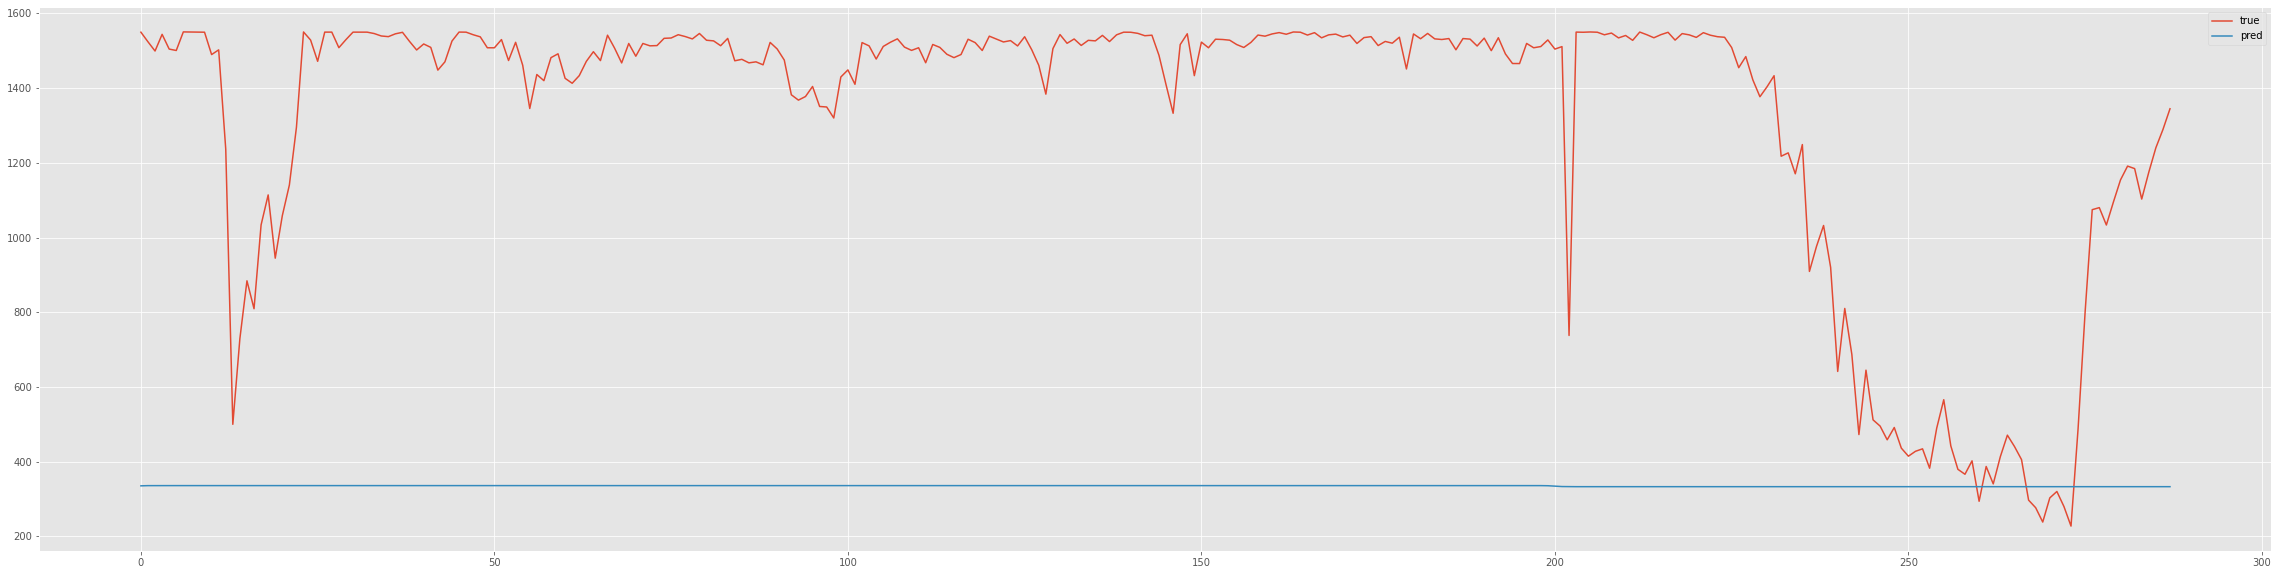

In [75]:
y_true = train_y[0]['Patv'].values
y_pred = model.predict(train_x[0].values[None, :])[0, :, -1]

fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(y_true, label='true')
ax.plot(y_pred, label='pred')
ax.legend();

## 2) Validation set

1/1 [==============================] - 0s 67ms/step


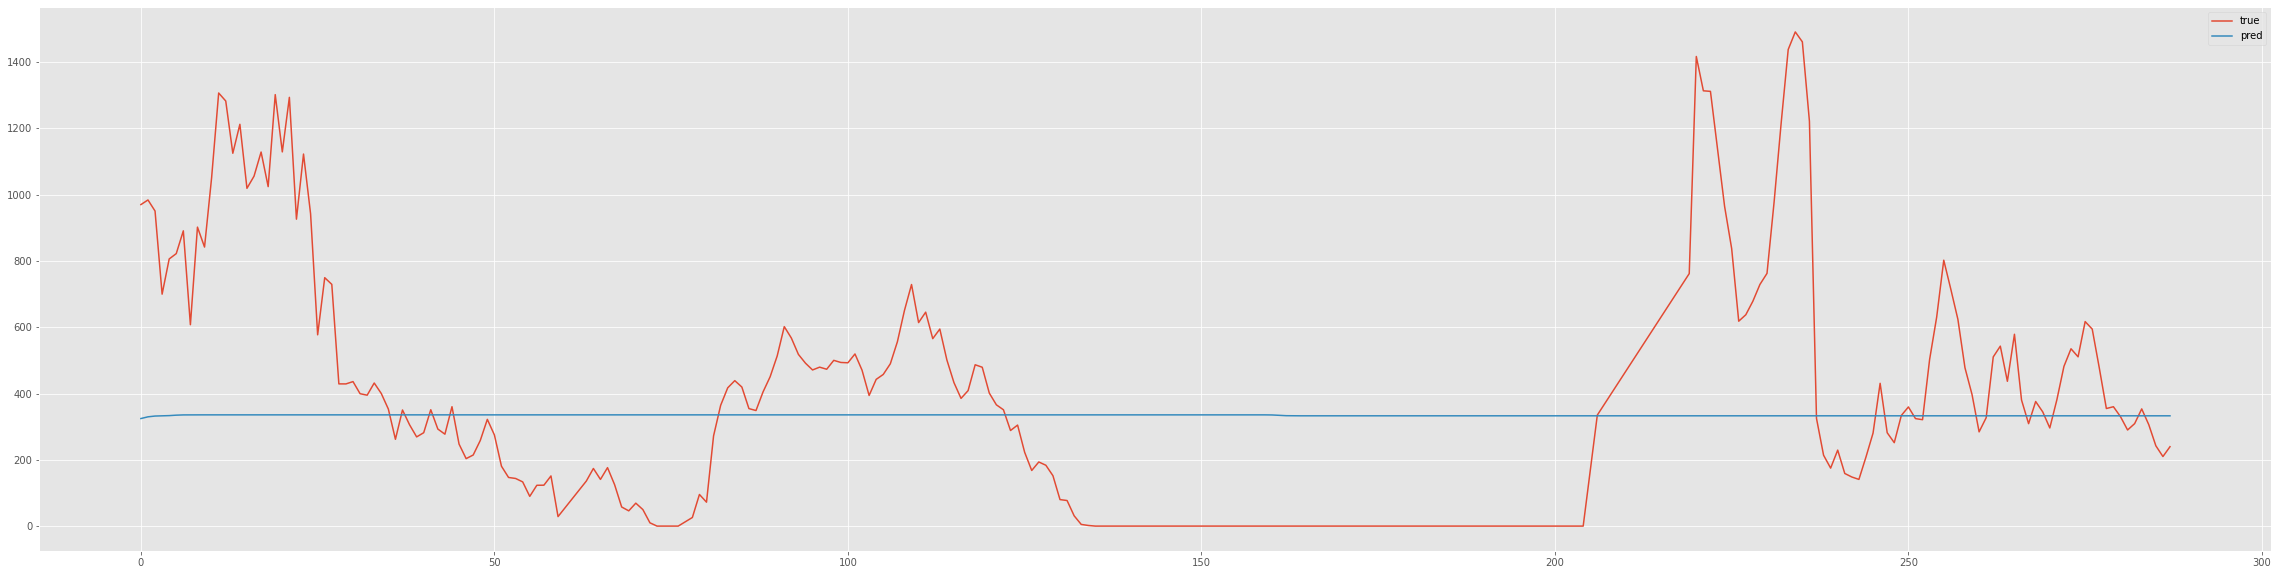

In [76]:
y_true = val_y[0]['Patv'].values
y_pred = model.predict(val_x[0].values[None, :])[0, :, -1]

fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(y_true, label='true')
ax.plot(y_pred, label='pred')
ax.legend();

# 6. Generate submission

In [90]:
sample_submission['Patv'] = model.predict(np.array(test_x))[:, :, -1].reshape(-1)
sample_submission.to_csv(join(PATH.output, "proposed16.csv"), index=False)

5/5 [==============================] - 0s 56ms/step
